# Pytorch 模型训练与可视化

一个深度学习项目包括了模型的设计、损失函数的设计、梯度更新的方法、模型的保存与加载、模型的训练过程等几个主要模块.深度学习，其实包括了三个最重要的核心过程：模型表示、方法评估、优化方法.
在一个模型中，我们要设置如下几个内容：
+ 模型定义。
+ 损失函数定义。
+ 优化器定义。

##### 构建训练数据

In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt

w = 2
b = 3
xlim = [-10, 10]
x_train = np.random.randint(low=xlim[0], high=xlim[1], size=30)

y_train = [w * x + b + random.randint(0,2) for x in x_train]
print(type(x_train), type(y_train))
plt.plot(x_train, y_train, 'bo')

###### 定义模型结构

In [2]:
import torch
from torch import nn

class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1))
    self.bias = nn.Parameter(torch.randn(1))

  def forward(self, input):
    return (input * self.weight) + self.bias

模型定义的要求：
1. **必须继承 nn.Module 类**。torch.nn.Module 是所有神经网络模块的基类。设计网络结构的时候，必须继承该类。
2. **重写__init__()方法**。通常来说要把有需要学习的参数的层放到构造函数中。初始化方法 __init__中必须调用父类的构造方法，即`super().__init__()`
3. **forward() 是必须重写的方法**。看用来定义这个模型是如何计算输出的，也就是前向传播。对于一些不需要学习参数的层，一般来说可以放在这里。例如，BN 层，激活函数还有 Dropout。

定义损失函数和优化器，进行模型训练

In [3]:
model = LinearModel()
#声明模型的损失函数
mseloss = nn.MSELoss()
# 定义优化器
optimizer= torch.optim.SGD(model.parameters(), lr =1e-4, weight_decay=1e-2,momentum=0.9)

x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.tensor(y_train,dtype=torch.float32)

# 定义训练过程
EPOCHS =100
for  _ in range(EPOCHS):
    input = x_train_tensor
    output = model(input)
    loss = mseloss(output, y_train_tensor)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    

可以通过 `named_parameters()` 来查看模型的可训练的参数

In [4]:
for parameter in model.named_parameters():
  print(parameter)


('weight', Parameter containing:
tensor([1.8711], requires_grad=True))
('bias', Parameter containing:
tensor([1.9085], requires_grad=True))


直接 `print(modelname)` 可以打印模型的网络结构

In [6]:
print(model)

LinearModel()


#### 模型保存与加载
###### 模型保存
只保存模型参数，不保存模型结构

In [7]:
# 只保存模型参数，不保存模型结构
torch.save(model.state_dict(), '../data/model/lineamodel.pth')


加载模型参数

In [13]:
# 先定义网络结构
linear_model = LinearModel()
# 加载保存的参数
linear_model.load_state_dict(torch.load('../data/model/lineamodel.pth'))
linear_model.eval()
for parameter in linear_model.named_parameters():
  print(parameter)

('weight', Parameter containing:
tensor([1.8711], requires_grad=True))
('bias', Parameter containing:
tensor([1.9085], requires_grad=True))


###### 保存网络结构与参数

In [16]:
torch.save(model, '../data/model/lineamodel_with_arc.pth')


In [17]:

# 加载模型，不需要创建网络了
linear_model_2 = torch.load('../data/model/lineamodel_with_arc.pth')
linear_model_2.eval()
for parameter in linear_model_2.named_parameters():
  print(parameter)


('weight', Parameter containing:
tensor([1.8711], requires_grad=True))
('bias', Parameter containing:
tensor([1.9085], requires_grad=True))


### 使用 Torchvison 中的模型进行训练
模型微调

In [2]:
# 拉取alexnet模型
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

/data/miniconda3/envs/py39_torch_cpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/miniconda3/envs/py39_torch_cpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import torch
from torch import nn
# 加载模型
import torchvision.models as models
alexnet = models.alexnet()
alexnet.load_state_dict(torch.load('/usr/local/app/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth'))

<All keys matched successfully>

In [5]:

from PIL import Image
import torchvision
import torchvision.transforms as transforms

im = Image.open('../data/img/dog.jpg')

transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

input_tensor = transform(im).unsqueeze(0)
alexnet(input_tensor).argmax()

tensor(151)

获取cifar10 数据集用于训练

Files already downloaded and verified
torch.Size([32, 3, 32, 32])


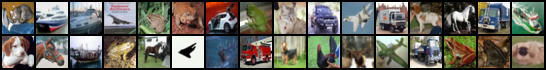

In [7]:
from torch.utils.data import DataLoader

cifar10_dataset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                       train=False,
                                       transform=transforms.ToTensor(),
                                       target_transform=None,
                                       download=True)
# 取32张图片的tensor
tensor_dataloader = DataLoader(dataset=cifar10_dataset,
                               batch_size=32)
data_iter = iter(tensor_dataloader)
img_tensor, label_tensor = data_iter.next()
print(img_tensor.shape)
grid_tensor = torchvision.utils.make_grid(img_tensor, nrow=16, padding=2)
grid_img = transforms.ToPILImage()(grid_tensor)
display(grid_img)

In [8]:
# 打印网络结构
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 微调模式：使用预训练模型重新训练全部参数

In [9]:
# 提取分类层的输入参数
fc_in_features = alexnet.classifier[6].in_features
# 修改预训练模型的输出分类数
alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:

transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
cifar10_dataset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                       train=False,
                                       transform=transform,
                                       target_transform=None,
                                       download=True)
dataloader = DataLoader(dataset=cifar10_dataset, # 传入的数据集, 必须参数
                               batch_size=32,       # 输出的batch大小
                               shuffle=True,       # 数据是否打乱
                               num_workers=2)      # 进程数, 0表示只有主进程

Files already downloaded and verified


In [12]:
#先定义优化器

optimizer = torch.optim.SGD(alexnet.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)
# 模型训练

# 训练3个Epoch
for epoch in range(3):
    for item in dataloader: 
        output = alexnet(item[0])
        target = item[1]
        # 使用交叉熵损失函数
        loss = nn.CrossEntropyLoss()(output, target)
        print('Epoch {}, Loss {}'.format(epoch + 1 , loss))
        #以下代码的含义，我们在之前的文章中已经介绍过了
        alexnet.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1, Loss 2.2912731170654297
Epoch 1, Loss 2.3878469467163086
Epoch 1, Loss 2.3763134479522705
Epoch 1, Loss 2.2168779373168945
Epoch 1, Loss 2.4542553424835205
Epoch 1, Loss 2.4314348697662354
Epoch 1, Loss 2.329298734664917
Epoch 1, Loss 2.5960075855255127
Epoch 1, Loss 2.3086729049682617
Epoch 1, Loss 2.416018009185791
Epoch 1, Loss 2.241990804672241
Epoch 1, Loss 2.167414903640747
Epoch 1, Loss 2.229670524597168
Epoch 1, Loss 2.355774402618408
Epoch 1, Loss 2.388242483139038
Epoch 1, Loss 2.2592756748199463
Epoch 1, Loss 2.2828614711761475
Epoch 1, Loss 2.3094146251678467
Epoch 1, Loss 2.194972276687622
Epoch 1, Loss 2.198899984359741
Epoch 1, Loss 2.2038862705230713
Epoch 1, Loss 2.226166248321533
Epoch 1, Loss 2.1445159912109375
Epoch 1, Loss 2.1299149990081787
Epoch 1, Loss 2.177553176879883
Epoch 1, Loss 2.161918878555298
Epoch 1, Loss 2.1898441314697266
Epoch 1, Loss 2.205780267715454
Epoch 1, Loss 2.0807933807373047
Epoch 1, Loss 2.0853638648986816
Epoch 1, Loss 2.1402471


KeyboardInterrupt



##### 微调模式2： 只重新训练输出层参数. 其它参数保持不变
只需要在读取完预训练模型之后，将全连接层之前的参数全部锁死即可，也就是让他们无法训练，我们模型训练时，只训练全连接层就行了，其余一切都不变。代码如下所示：

In [13]:

alexnet = models.alexnet()
alexnet.load_state_dict(torch.load('/usr/local/app/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth'))
for param in alexnet.parameters():
    param.requires_grad = False

### 模型可视化
#### TensorboardX使用

In [2]:
import torch
torch.utils.tensorboard.writer.SummaryWriter(log_dir='/ceph/11027/test')

In [5]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(log_dir='/ceph/11027/test')
for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)    
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)
    img = np.zeros((3, 100, 100))
    img[0] = np.arange(0, 10000).reshape(100, 100) / 10000
    img[1] = 1 - np.arange(0, 10000).reshape(100, 100) / 10000
    writer.add_image('my_image', img, 0)
    writer.close()

Linear 使用 tensorboardx

In [6]:

import random
import numpy as np
import torch
from torch import nn

# 模型定义
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1))
    self.bias = nn.Parameter(torch.randn(1))

  def forward(self, input):
    return (input * self.weight) + self.bias

# 数据
w = 2
b = 3
xlim = [-10, 10]
x_train = np.random.randint(low=xlim[0], high=xlim[1], size=30)
y_train = [w * x + b + random.randint(0,2) for x in x_train]

In [9]:

# Tensorboard
from torch.utils.tensorboard import SummaryWriter

# 训练
model = LinearModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)
y_train = torch.tensor(y_train, dtype=torch.float32)

writer = SummaryWriter(log_dir='/ceph/11027/test')

for n_iter in range(500):
    input = torch.from_numpy(x_train)
    output = model(input)
    loss = nn.MSELoss()(output, y_train)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    writer.add_scalar('Loss/train', loss, n_iter)

/tmp/ipykernel_24955/723533739.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
